In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skrf as rf
rf.stylely()

In this notebook, we determine the short-circuit lengths and impedances in order to match low-power measurements. 

# Low power measurements

In [2]:
filename = 'data/RES2.ASC'

In [3]:
exp_freq,reS11,imS11 = np.loadtxt(filename, skiprows=14, delimiter=';', unpack=True)

In [4]:
exp_mag = np.sqrt(reS11**2 + imS11**2)
exp_mag_dB = 20*np.log10(exp_mag)
# find the match frequency 
exp_freq_match = exp_freq[np.argmin(exp_mag)]
print('Match frequency : {} MHz'.format(exp_freq_match/1e6))

Match frequency : 62.640625 MHz


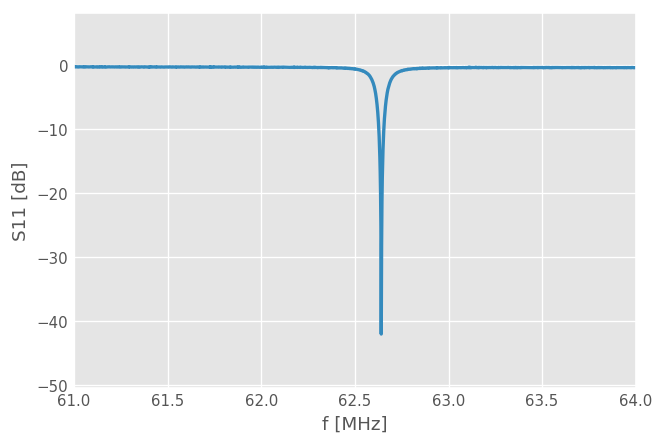

In [5]:
fig,ax = plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB, lw=2)
ax.grid(True)
ax.set_ylabel('S11 [dB]')
ax.set_xlabel('f [MHz]')

# Electromagnetic Model

In [6]:
# Importing T-resonator S-parameters from HFSS 
resonator_base = rf.Network('data/SSA50_resonator_RFModels_Resonator_Base.s4p', f_unit='MHz')

In [7]:
# Coaxial media associated to transmission line for service stub and short circuits
service_stub_media = rf.media.Coaxial(frequency=resonator_base.frequency, Dint=55.5e-3, Dout=152e-3, epsilon_r=1)
sc_CEA_media = rf.media.Coaxial(frequency=resonator_base.frequency, Dint=140e-3, Dout=219e-3, epsilon_r=1)
sc_DUT_media = rf.media.Coaxial(frequency=resonator_base.frequency, Dint=127.92e-3, Dout=216e-3, epsilon_r=1)

In [8]:
# Creating networks for service stubs and shorts
def resonator_network(d_sc_CEA = 100e-3, Z_sc_CEA = 1e-3, 
                      d_sc_DUT = 33e-3, Z_sc_DUT = 1e-3, 
                      d_sstub = 50e-3):
    '''
    Create and return the resonator Network from specified short-circuit lengths and resistances
    '''
    # Creating transmission line medias 
    service_stub = service_stub_media.line(d_sstub, unit='m') ** service_stub_media.short()
    sc_CEA = sc_CEA_media.line(d_sc_CEA, unit='m')**sc_CEA_media.resistor(Z_sc_CEA)**sc_CEA_media.short()
    sc_DUT = sc_DUT_media.line(d_sc_DUT, unit='m')**sc_DUT_media.resistor(Z_sc_DUT)**sc_DUT_media.short()
    # Connecting the resonator with its ports. 
    # Port 1 : resonator input
    # Port 2 : DUT
    # Port 3 : CEA
    # Port 4: service stub
    _res = rf.connect(resonator_base, 3, service_stub, 0) # resonator to service stub 
    _res = rf.connect(_res, 2, sc_CEA, 0) # resonator to CEA
    res = rf.connect(_res, 1, sc_DUT, 0) # resonator to DUT
    return res

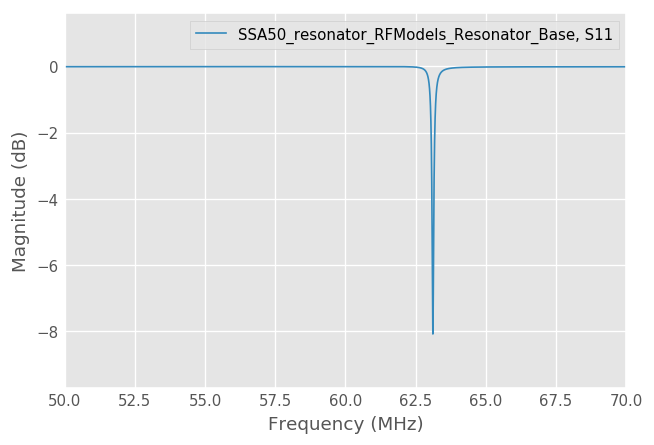

In [9]:
# Plot the default values resonator Network
res=resonator_network()
res.plot_s_db()

# Optimizing short-circuit length

In [10]:
from scipy.optimize import minimize

In [11]:
# Search the optimal DUT and CEA short lengths 
# in order to have the matching frequency corresponding 
# to the experimental matching frequency
def f_match(resonator_network):
    'Return the resonator match frequency'
    return resonator_network.frequency[resonator_network.s_mag.argmin()].f[0]

def optim_fun_length(short_lengths, f_target):
    'Generates a resonator network from short lengths (DUT,CEA) and returns the difference to match frequency'
    d_DUT, d_CEA = short_lengths
    
    res = resonator_network(d_sc_CEA=d_CEA, d_sc_DUT=d_DUT)
    return np.abs(f_target - f_match(res))/1e6

In [12]:
d_CEA_0 = 50e-3
d_DUT_0 = 30e-3
bounds=((33e-3, 63e-3),(5e-3, 200e-3))

In [13]:
opt_res = minimize(optim_fun_length, (d_DUT_0, d_CEA_0), args=(exp_freq_match), 
         options={'disp': True}, method='Nelder-Mead')

print(opt_res)
d_DUT_opt, d_CEA_opt = opt_res.x

Optimization terminated successfully.
         Current function value: 0.000375
         Iterations: 28
         Function evaluations: 60
 final_simplex: (array([[ 0.07081975,  0.06295646],
       [ 0.0708004 ,  0.06301165],
       [ 0.07082117,  0.06294651]]), array([ 0.000375,  0.000375,  0.000375]))
           fun: 0.00037500000000000001
       message: 'Optimization terminated successfully.'
          nfev: 60
           nit: 28
        status: 0
       success: True
             x: array([ 0.07081975,  0.06295646])


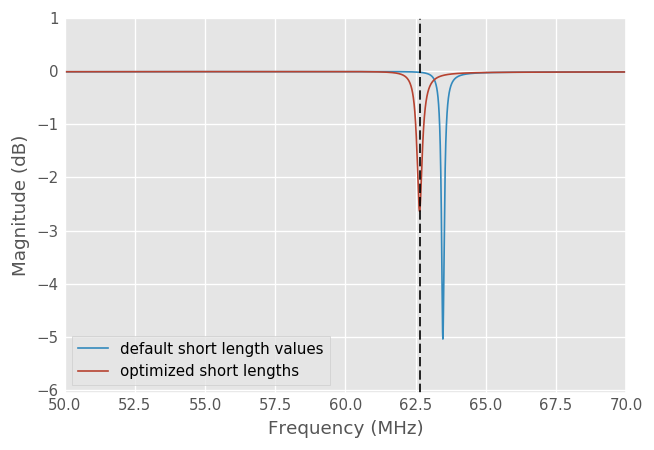

In [14]:
resonator_network(d_sc_DUT=d_DUT_0, d_sc_CEA=d_CEA_0).plot_s_db()
resonator_network(d_sc_DUT=d_DUT_opt, d_sc_CEA=d_CEA_opt).plot_s_db()
plt.axvline(exp_freq_match/1e6, color='k', ls='--')

plt.legend(('default short length values', 'optimized short lengths'))

# Optimized Parameters (length and impedance)

Now that we now the optimized short lengths in order to get the match frequency, let's optimize the short impedance in order to fit the resonator experimental Q quality factor.   

In [22]:
def optim_fun_impedance(short_properties):
    'Generates a resonator network from short impedance (Z_DUT,Z_CEA) and returns t'
    d_DUT, Z_DUT, d_CEA, Z_CEA, d_sstub = short_properties
    # calculates the resonator Network
    res = resonator_network(d_sc_CEA=d_CEA, d_sc_DUT=d_DUT, 
                            Z_sc_CEA=Z_CEA, Z_sc_DUT=Z_DUT,
                            d_sstub=d_sstub)
    
    # The experimental frequency band does not match the HFSS simulated one.  
    # So before making any operations between Networks, need to interpolate them
    exp_frequency = rf.frequency.f_2_frequency(exp_freq)
    res_exp_freq = res.interpolate_from_f(exp_frequency)

    return np.sum( (res_exp_freq.s_mag.squeeze() - exp_mag)**2)

In [23]:
Z_DUT_0 = 1e-3 # Ohm
Z_CEA_0 = 1e-3 # Ohm
d_sstub_0 = 0
bounds_pties = ((33e-3, 63e-3), (1e-4, 10), # DUT
                (5e-3, 200e-3), (1e-4, 10), # CEA
                (0, 900e-3)) # service stub
optim_fun_impedance((d_DUT_opt, Z_DUT_0, d_CEA_opt, Z_CEA_0, d_sstub_0))

7.9900700863520786

In [24]:
opt_res = minimize(optim_fun_impedance, (d_DUT_opt, Z_DUT_0, d_CEA_opt, Z_CEA_0, d_sstub_0),
                  bounds=bounds_pties)

In [26]:
print(opt_res)
d_DUT_opt2, Z_DUT_opt, d_CEA_opt2, Z_CEA_opt, d_sstub_opt = opt_res.x

      fun: 1.8788819216223094
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.82324378e-02,  -5.23801003e-03,  -4.62636596e-03,
        -3.53626017e-03,  -1.98285832e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 444
      nit: 60
   status: 0
  success: True
        x: array([ 0.03882602,  0.00695807,  0.16119716,  0.03314729,  0.12435092])


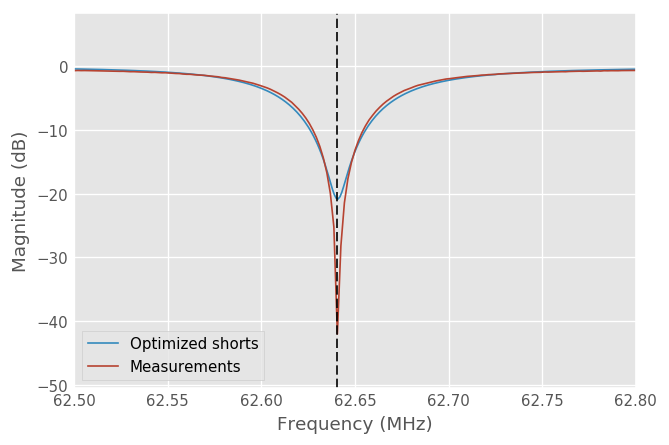

In [28]:
#resonator_network(d_sc_DUT=d_DUT_opt2, d_sc_CEA=d_CEA_opt2, Z_sc_CEA=Z_CEA_opt, Z_sc_DUT=Z_DUT_opt, d_sstub=0).plot_s_db()
resonator_network(d_sc_DUT=d_DUT_opt2, d_sc_CEA=d_CEA_opt2, Z_sc_CEA=Z_CEA_opt, Z_sc_DUT=Z_DUT_opt, d_sstub=d_sstub_opt).plot_s_db()
plt.plot(exp_freq/1e6, exp_mag_dB)
plt.xlim(62.5, 62.8)
plt.axvline(exp_freq_match/1e6, color='k', ls='--')
plt.legend(('Optimized shorts', 'Measurements'))

First set of optimized set of values 11/04/2017: 
DUT length : 0.03886977 m
DUT impedance : 0.00613262 Ohm 
CEA length : 0.16084317 m
CEA impedance : 0.03340997 Ohm

Second set of optimized values
DUT length : 0.0389024 ,  
DUT impedance : 0.00656238,  
CEA length : 0.16075725,  
CEA impedance :  0.03439415
 
Third set of optimized values with service stub
DUT length : 0.03882602,  
DUT impedance : 0.00695807,  
CEA length : 0.16119716,  
CEA impedance :  0.03314729,  
service-stub length :  0.12435092
